In [283]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import src.plotter.utils as utils
from src.plotter.main import *
from copy import deepcopy
import math

def truncate(number, digits) -> float:
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

In [297]:
BATCH_RESULT_PATH = "C:/Users/SK3LA/Desktop/WORKSPACE/1_TSP/BATCH_FINALI/@RISULTATI@/res/GAUSIGMA2/"
OUTPUT_DIRECTORY_PATH = f"C:/Users/SK3LA/Desktop/WORKSPACE/1_TSP/BATCH_FINALI/@RISULTATI@/plot/GAUSIGMA2/aggregated-{BATCH_RESULT_PATH.split('/')[-2]}-new/"

DEADLINES = [1, 5]
TIMESLOTS = 10000

In [287]:
def get_results_path(start_path=BATCH_RESULT_PATH):
    to_ret = []

    for file in os.listdir(start_path):
        if os.path.isdir(os.path.join(start_path, file)):
            to_ret.append(os.path.join(start_path, file, 'results.data'))

    return to_ret

results_path = get_results_path()

In [71]:
# slices_std = split_stats_per_slice(imported_data[policy_index]['environment_data_std'])

In [288]:
BATCH_RESULT_PATH

'C:/Users/SK3LA/Desktop/WORKSPACE/1_TSP/BATCH_FINALI/@RISULTATI@/res/GAUSIGMA2/'

In [298]:
# getting policies_aggregated_stats 

policies_aggregated_stats = None

for r in results_path:
    imported_data = utils.import_serialized_data(r)
    if policies_aggregated_stats is None:
        policies_aggregated_stats = [{'name': imported_data[i]['name'], 'stats_per_slice': []} for i in range(len(imported_data))]

    for policy_index in range(len(imported_data)):
        policies_aggregated_stats[policy_index]['stats_per_slice'].append(
            {
             # the way we calculate the server_cap assumes the directory name like "something_NUMBEROFSERVERS"
             'server_cap': r.replace("\\", "/").split('/')[-2].split('_')[1],
             'slices': []
             }
        )

        slices = filter_stats_per_slice(split_stats_per_slice(imported_data[policy_index]['environment_data']))
#         slices_std = split_stats_per_slice(imported_data[policy_index]['environment_data_std'])

        policies_aggregated_stats[policy_index]['stats_per_slice'][-1]['slices'].append(
            {
                'processed_jobs': sum(slices[0]['processed_jobs']),
                'incoming_jobs': sum(slices[0]['incoming_jobs']),
                'lost_jobs': sum(slices[0]['lost_jobs']),
                'toolate_jobs': sum(slices[0]['processed_jobs']) * sum(slices[0]['wait_time_in_the_system'][DEADLINES[0]:]),
                'cost': sum(slices[0]['cost']),
                'cost_component': np.array(slices[0]['cost_component']).sum(0).tolist(),
#                 'cost_std': sum(slices_std[0]['cost'])
             }
        )

        policies_aggregated_stats[policy_index]['stats_per_slice'][-1]['slices'].append(
            {
                'processed_jobs': sum(slices[1]['processed_jobs']),
                'incoming_jobs': sum(slices[1]['incoming_jobs']),
                'lost_jobs': sum(slices[1]['lost_jobs']),
                'toolate_jobs': sum(slices[1]['processed_jobs']) * sum(slices[1]['wait_time_in_the_system'][DEADLINES[1]:]),
                'cost': sum(slices[1]['cost']),
                'cost_component': np.array(slices[1]['cost_component']).sum(0).tolist(),
#                 'cost_std': sum(slices_std[1]['cost'])
            }
        )
        
dataframes = []

for policy in policies_aggregated_stats:
    servers_list = []
    processed_on_time_percent = [[], []]
    processed_too_late_percent = [[], []]
    lost_percent = [[], []]

    cost_job = [[], []]
    cost_server = [[], []]
    cost_lost = [[], []]
    cost_alloc = [[], []]
    cost_dealloc = [[], []]

    costs = [[], []]
    
#     costs_std = [[], []]

    for s in policy['stats_per_slice']:
        servers_list.append(s['server_cap'])

        lost_percent[0].append((s['slices'][0]['lost_jobs'] * 100) / s['slices'][0]['incoming_jobs'])
        lost_percent[1].append((s['slices'][1]['lost_jobs'] * 100) / s['slices'][1]['incoming_jobs'])

        processed_too_late_percent[0].append((s['slices'][0]['toolate_jobs'] * 100) / s['slices'][0]['incoming_jobs'])
        processed_too_late_percent[1].append((s['slices'][1]['toolate_jobs'] * 100) / s['slices'][1]['incoming_jobs'])

        s['slices'][0]['processed_jobs'] -= s['slices'][0]['toolate_jobs']
        s['slices'][1]['processed_jobs'] -= s['slices'][1]['toolate_jobs']

        processed_on_time_percent[0].append((s['slices'][0]['processed_jobs'] * 100) / s['slices'][0]['incoming_jobs'])
        processed_on_time_percent[1].append((s['slices'][1]['processed_jobs'] * 100) / s['slices'][1]['incoming_jobs'])

        cost_job[0].append(s['slices'][0]['cost_component'][0])
        cost_job[1].append(s['slices'][1]['cost_component'][0])

        cost_server[0].append(s['slices'][0]['cost_component'][1])
        cost_server[1].append(s['slices'][1]['cost_component'][1])

        cost_lost[0].append(s['slices'][0]['cost_component'][2])
        cost_lost[1].append(s['slices'][1]['cost_component'][2])

        cost_alloc[0].append(s['slices'][0]['cost_component'][3])
        cost_alloc[1].append(s['slices'][1]['cost_component'][3])

        cost_dealloc[0].append(s['slices'][0]['cost_component'][4])
        cost_dealloc[1].append(s['slices'][1]['cost_component'][4])

        costs[0].append(s['slices'][0]['cost'])
        costs[1].append(s['slices'][1]['cost'])
        
#         costs_std[0].append(s['slices'][0]['cost_std'])
#         costs_std[1].append(s['slices'][1]['cost_std'])

    dataframes.append(
        {
            'name': policy['name'],
            'slices': [
                pd.DataFrame({  # slice high priority
                    'server': servers_list,
                    'processed_on_time': processed_on_time_percent[0],
                    'processed_too_late': processed_too_late_percent[0],
                    'lost': lost_percent[0],
                    'cost_job': cost_job[0],
                    'cost_server': cost_server[0],
                    'cost_lost': cost_lost[0],
                    'cost_alloc': cost_alloc[0],
                    'cost_dealloc': cost_dealloc[0],
                    'cost_sum': costs[0],
#                     'cost_sum_std': costs_std[0]
                }),
                pd.DataFrame({  # slice low priority
                    'server': servers_list,
                    'processed_on_time': processed_on_time_percent[1],
                    'processed_too_late': processed_too_late_percent[1],
                    'lost': lost_percent[1],
                    'cost_job': cost_job[1],
                    'cost_server': cost_server[1],
                    'cost_lost': cost_lost[1],
                    'cost_alloc': cost_alloc[1],
                    'cost_dealloc': cost_dealloc[1],
                    'cost_sum': costs[1],
#                     'cost_sum_std': costs_std[1]
                })  # .sort_values(by=["server"]).set_index("server")
            ]
        }
    )

    dataframes[-1]['slices'][0]['server'] = dataframes[-1]['slices'][0].astype(int)
    dataframes[-1]['slices'][1]['server'] = dataframes[-1]['slices'][1].astype(int)
    dataframes[-1]['slices'][0] = dataframes[-1]['slices'][0].sort_values(by=["server"]).set_index("server")
    dataframes[-1]['slices'][1] = dataframes[-1]['slices'][1].sort_values(by=["server"]).set_index("server")

In [299]:
# slice_0 = [d['slices'][0] for d in dataframes]
# slice_1 = [d['slices'][1] for d in dataframes]

# df_processed_on_time_slice_0 = \
#     pd.DataFrame({
#         'server': slice_0[0].index.to_list(),
#         'SequentialMDP': slice_0[0]['processed_on_time'].to_list(),
#         'SimplifiedMDP': slice_0[1]['processed_on_time'].to_list(),
#         'UniformStatic': slice_0[2]['processed_on_time'].to_list(),
#         'PriorityStatic': slice_0[3]['processed_on_time'].to_list(),
#                  })

# df_processed_on_time_slice_0['server'] = df_processed_on_time_slice_0['server'].astype(int)
# df_processed_on_time_slice_0 = df_processed_on_time_slice_0.sort_values(by=["server"]).set_index("server")


    
# df_processed_on_time_slice_1 = \
#     pd.DataFrame({
#         'server': slice_1[0].index.to_list(),
#         'SequentialMDP': slice_1[0]['processed_on_time'].to_list(),
#         'SimplifiedMDP': slice_1[1]['processed_on_time'].to_list(),
#         'UniformStatic': slice_1[2]['processed_on_time'].to_list(),
#         'PriorityStatic': slice_1[3]['processed_on_time'].to_list(),
#     })

# df_processed_on_time_slice_1['server'] = df_processed_on_time_slice_1['server'].astype(int)
# df_processed_on_time_slice_1 = df_processed_on_time_slice_1.sort_values(by=["server"]).set_index("server")

slice_0 = [d['slices'][0] for d in dataframes]
slice_1 = [d['slices'][1] for d in dataframes]

df_processed_on_time_slice_0 = \
    pd.DataFrame({
        'server': slice_0[0].index.to_list(),
        'SequentialMDP': slice_0[0]['processed_on_time'].to_list(),
        'SimplifiedMDP': slice_0[1]['processed_on_time'].to_list(),
        'ConservativeMDP': slice_0[3]['processed_on_time'].to_list(),
        'UniformStatic': slice_0[2]['processed_on_time'].to_list(),
        'PriorityStatic': slice_0[3]['processed_on_time'].to_list(),
                 })

df_processed_on_time_slice_0['server'] = df_processed_on_time_slice_0['server'].astype(int)
df_processed_on_time_slice_0 = df_processed_on_time_slice_0.sort_values(by=["server"]).set_index("server")


    
df_processed_on_time_slice_1 = \
    pd.DataFrame({
        'server': slice_1[0].index.to_list(),
        'SequentialMDP': slice_1[0]['processed_on_time'].to_list(),
        'SimplifiedMDP': slice_1[1]['processed_on_time'].to_list(),
        'ConservativeMDP': slice_1[1]['processed_on_time'].to_list(),
        'UniformStatic': slice_1[2]['processed_on_time'].to_list(),
        'PriorityStatic': slice_1[3]['processed_on_time'].to_list(),
    })

df_processed_on_time_slice_1['server'] = df_processed_on_time_slice_1['server'].astype(int)
df_processed_on_time_slice_1 = df_processed_on_time_slice_1.sort_values(by=["server"]).set_index("server")

In [300]:
df_processed_on_time_slice_0

,SequentialMDP,SimplifiedMDP,ConservativeMDP,UniformStatic,PriorityStatic
server,,,,,
2,0.010373,0.011466,0.010910,0.003062,0.010910
3,18.593986,18.635843,18.542467,0.010348,18.542467
4,95.532363,95.560714,95.553704,0.009407,95.553704
5,96.598422,96.596271,99.748917,18.392798,99.748917
6,96.658071,96.671231,99.991213,18.617954,99.991213
7,96.674709,96.686129,99.999812,95.524358,99.999812
8,96.657181,96.690272,99.999969,95.482727,99.999969
9,96.687299,96.698976,100.000000,99.750592,100.000000
10,96.641002,96.678179,99.999844,99.745513,99.999844


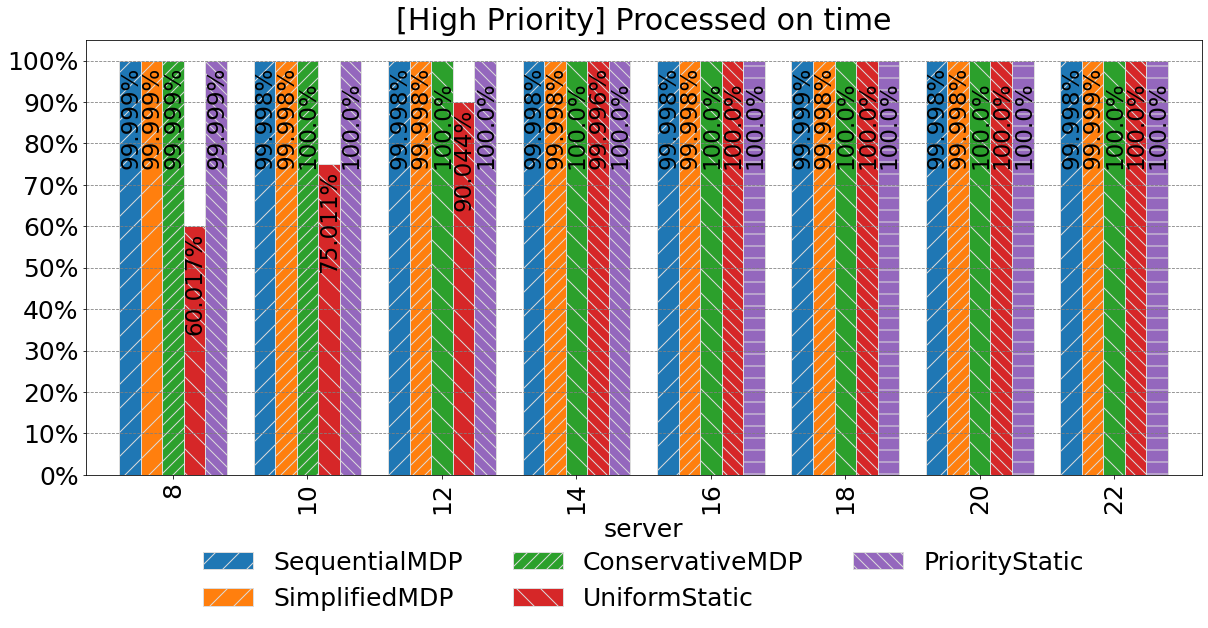

In [43]:
patterns =('/','//', '\\', '\\\\', '-')

ax = df_processed_on_time_slice_0[1:10].plot(
        kind='bar',
        stacked=False,
        figsize=(20, 8),
        width=0.8,
    )
ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_title(f"[High Priority] Processed on time", pad=10)
yticks = np.arange(0, 101, 10)
ylabels = ['{}%'.format(i) for i in np.arange(0, 101, 10)]
plt.yticks(yticks, ylabels)


# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    if i.get_height() > 20:
        ax.text(i.get_x() + 0., i.get_height() - 25,
                str(round((i.get_height()), 3)) + '%', fontsize=23, color='black', rotation=90)
    else:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x() + 0., i.get_height() + 3,
                str(round((i.get_height()), 3)) + '%', fontsize=23, color='black', rotation=90)

plt.rcParams.update({'font.size': 25})
fig_background_color = 'skyblue'
fig_border = 'steelblue'

bars = ax.patches

hatches = [p for p in patterns for i in range(len(df_processed_on_time_slice_0))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    bar.set_edgecolor('gainsboro')
    
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)
    
# plt.show()

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}processed_on_time_slice0_allpolicy_JUPYTER", bbox_inches='tight')
            
            

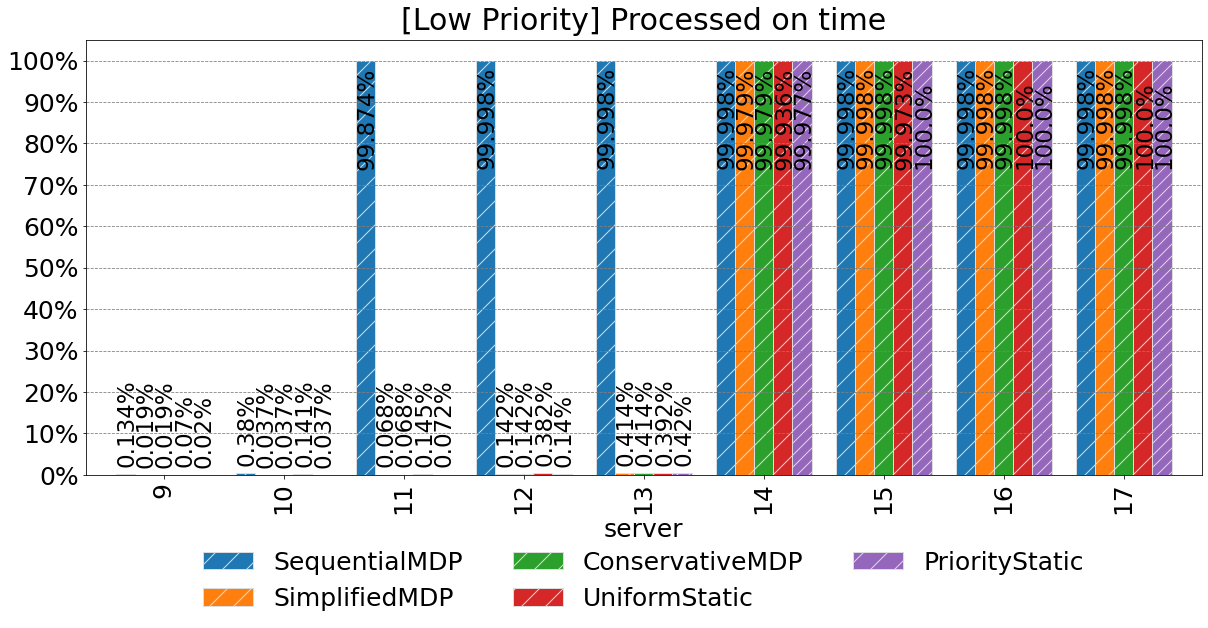

In [82]:
patterns =('/','//', '\\', '\\\\', '-')

ax = df_processed_on_time_slice_1[7:16].plot(
        kind='bar',
        stacked=False,
        figsize=(20, 8),
        width=0.8,
    )
ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_title(f"[Low Priority] Processed on time", pad=10)
yticks = np.arange(0, 101, 10)
ylabels = ['{}%'.format(i) for i in np.arange(0, 101, 10)]
plt.yticks(yticks, ylabels)


# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    if i.get_height() > 20:
        ax.text(i.get_x() + 0., i.get_height() - 25,
                str(round((i.get_height()), 3)) + '%', fontsize=23, color='black', rotation=90)
    else:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x() + 0., i.get_height() + 3,
                str(round((i.get_height()), 3)) + '%', fontsize=23, color='black', rotation=90)

plt.rcParams.update({'font.size': 25})
fig_background_color = 'skyblue'
fig_border = 'steelblue'

bars = ax.patches

hatches = [p for p in patterns for i in range(len(df_processed_on_time_slice_0))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    bar.set_edgecolor('gainsboro')
    
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)
    
# plt.show()

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}processed_on_time_slice1_allpolicy_JUPYTER", bbox_inches='tight')
            

In [301]:
# slice_0 = [d['slices'][0] for d in dataframes]
# slice_1 = [d['slices'][1] for d in dataframes]

# df_cost_slice_0 = \
#     pd.DataFrame({
#         'server': slice_0[0].index.to_list(),
#         'SequentialMDP': (slice_0[0]['cost_sum']/TIMESLOTS).to_list(),
#         'SimplifiedMDP': (slice_0[1]['cost_sum']/TIMESLOTS).to_list(),
#         'UniformStatic': (slice_0[2]['cost_sum']/TIMESLOTS).to_list(),
#         'PriorityStatic': (slice_0[3]['cost_sum']/TIMESLOTS).to_list(),
#                  })

# df_cost_slice_0['server'] = df_cost_slice_0['server'].astype(int)
# df_cost_slice_0 = df_cost_slice_0.sort_values(by=["server"]).set_index("server")


    
# df_cost_slice_1 = \
#     pd.DataFrame({
#         'server': slice_1[0].index.to_list(),
#         'SequentialMDP': (slice_1[0]['cost_sum']/TIMESLOTS).to_list(),
#         'SimplifiedMDP': (slice_1[1]['cost_sum']/TIMESLOTS).to_list(),
#         'UniformStatic': (slice_1[2]['cost_sum']/TIMESLOTS).to_list(),
#         'PriorityStatic': (slice_1[3]['cost_sum']/TIMESLOTS).to_list(),
#     })

# df_cost_slice_1['server'] = df_cost_slice_1['server'].astype(int)
# df_cost_slice_1 = df_cost_slice_1.sort_values(by=["server"]).set_index("server")

slice_0 = [d['slices'][0] for d in dataframes]
slice_1 = [d['slices'][1] for d in dataframes]

df_cost_slice_0 = \
    pd.DataFrame({
        'server': slice_0[0].index.to_list(),
        'SequentialMDP': (slice_0[0]['cost_sum']/TIMESLOTS).to_list(),
        'SimplifiedMDP': (slice_0[1]['cost_sum']/TIMESLOTS).to_list(),
        'ConservativeMDP': (slice_0[3]['cost_sum']/TIMESLOTS).to_list(),
        'UniformStatic': (slice_0[2]['cost_sum']/TIMESLOTS).to_list(),
        'PriorityStatic': (slice_0[3]['cost_sum']/TIMESLOTS).to_list(),
                 })

df_cost_slice_0['server'] = df_cost_slice_0['server'].astype(int)
df_cost_slice_0 = df_cost_slice_0.sort_values(by=["server"]).set_index("server")


    
df_cost_slice_1 = \
    pd.DataFrame({
        'server': slice_1[0].index.to_list(),
        'SequentialMDP': (slice_1[0]['cost_sum']/TIMESLOTS).to_list(),
        'SimplifiedMDP': (slice_1[1]['cost_sum']/TIMESLOTS).to_list(),
        'ConservativeMDP': (slice_1[1]['cost_sum']/TIMESLOTS).to_list(),
        'UniformStatic': (slice_1[2]['cost_sum']/TIMESLOTS).to_list(),
        'PriorityStatic': (slice_1[3]['cost_sum']/TIMESLOTS).to_list(),
    })

df_cost_slice_1['server'] = df_cost_slice_1['server'].astype(int)
df_cost_slice_1 = df_cost_slice_1.sort_values(by=["server"]).set_index("server")

In [169]:
slice_1[0]

,processed_on_time,processed_too_late,lost,cost_job,cost_server,cost_lost,cost_alloc,cost_dealloc,cost_sum
server,,,,,,,,,
6,0.000000,0.000000,99.899984,6.196527,0.000000,6.192788e-01,0.000000,0.000000,6.815805
8,12.761880,0.068454,87.071068,6.116532,0.082526,5.398476e-01,0.008391,0.000009,6.747305
10,42.896302,0.000000,57.006867,5.928399,0.275799,3.533289e-01,0.011680,0.000012,6.569219
12,72.912672,0.000000,26.992668,5.722762,0.468241,1.672932e-01,0.012199,0.000013,6.370508
14,99.990572,0.000000,0.000100,0.476571,0.660830,6.200000e-07,0.012360,0.000013,1.149773
16,99.997899,0.000000,0.000000,0.022828,0.686931,0.000000e+00,0.012972,0.000013,0.722744
18,99.998600,0.000000,0.000000,0.019354,0.688235,0.000000e+00,0.012216,0.000013,0.719817
20,99.998400,0.000000,0.000000,0.019282,0.688637,0.000000e+00,0.012298,0.000013,0.720230
22,99.998300,0.000000,0.000000,0.019285,0.688691,0.000000e+00,0.012300,0.000013,0.720288


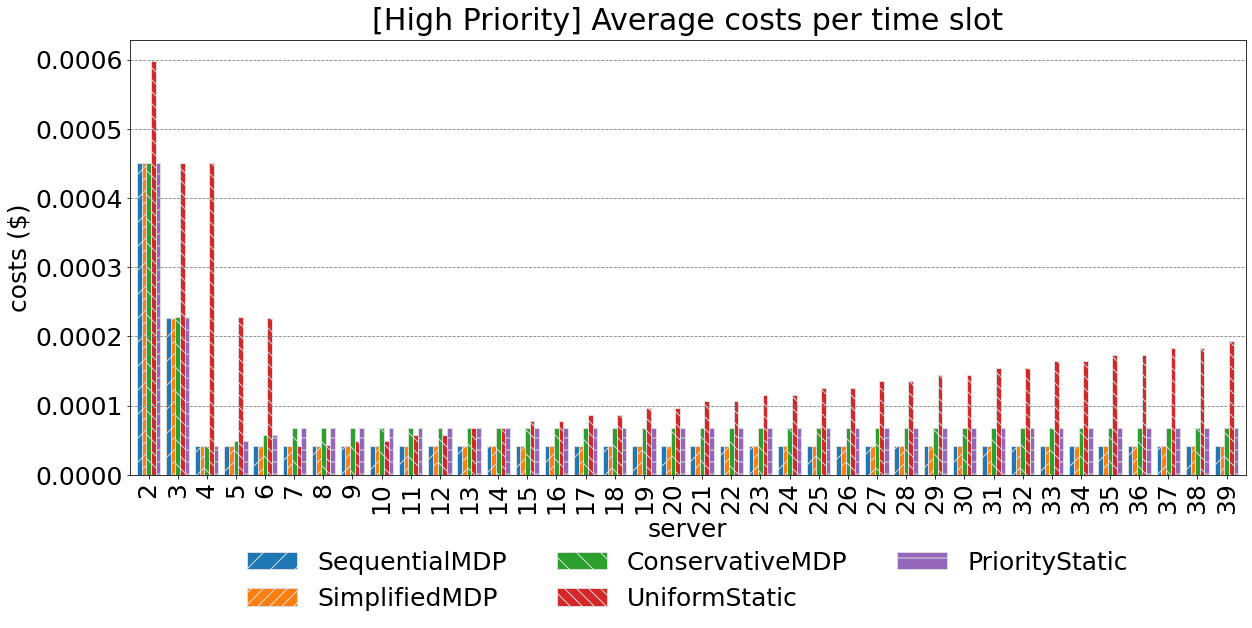

In [66]:
patterns =('/','//', '\\', '\\\\', '-')

ax = df_cost_slice_0.plot(
        kind='bar',
        stacked=False,
        figsize=(20, 8),
        width=0.8,
#         logy=True
    )

ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_title(f"[High Priority] Average costs per time slot", pad=10)
ax.set_ylabel('costs ($)')

plt.rcParams.update({'font.size': 25})
fig_background_color = 'skyblue'
fig_border = 'steelblue'

bars = ax.patches

hatches = [p for p in patterns for i in range(len(df_processed_on_time_slice_0))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    bar.set_edgecolor('gainsboro')
    
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}cost_slice0_allpolicy_JUPYTER", bbox_inches='tight')

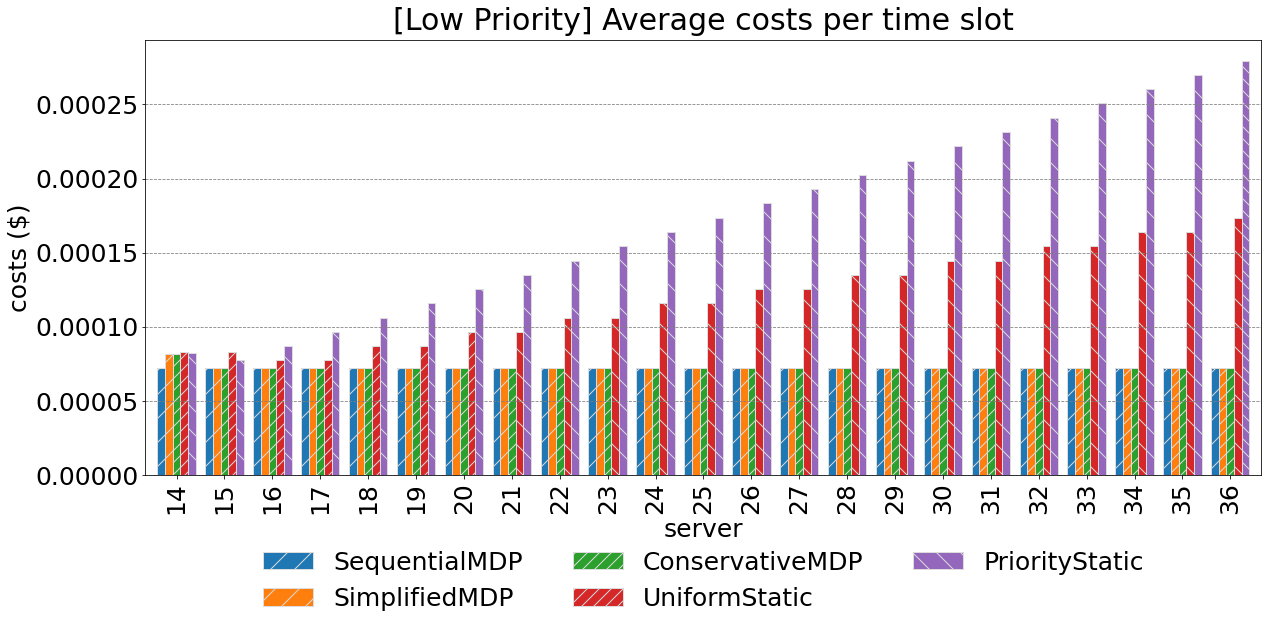

In [70]:
patterns =('/','//', '\\', '\\\\', '-')

ax = df_cost_slice_1[12:35].plot(
        kind='bar',
        stacked=False,
        figsize=(20, 8),
        width=0.8,
#         logy=True
    )

ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_title(f"[Low Priority] Average costs per time slot", pad=10)
ax.set_ylabel('costs ($)')

plt.rcParams.update({'font.size': 25})
fig_background_color = 'skyblue'
fig_border = 'steelblue'

bars = ax.patches

hatches = [p for p in patterns for i in range(len(df_processed_on_time_slice_0))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    bar.set_edgecolor('gainsboro')
    
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}cost_slice1_allpolicy_JUPYTER", bbox_inches='tight')

IndexError: index 0 is out of bounds for axis 0 with size 0

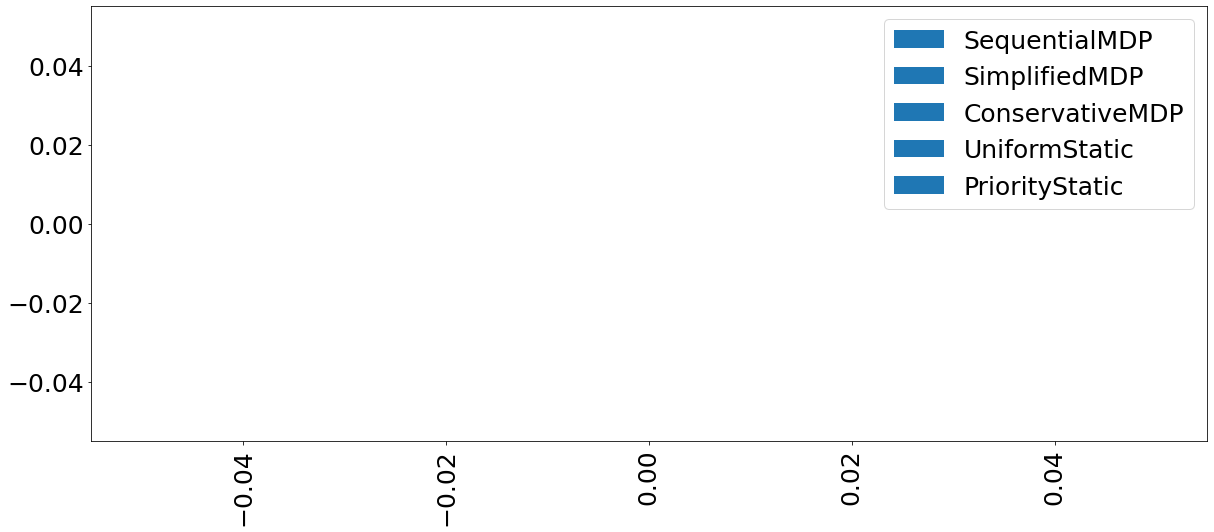

In [48]:
patterns =('/','//', '\\', '\\\\', '-')

ax = (df_cost_slice_0 + df_cost_slice_1)[12:35].plot(
        kind='bar',
        stacked=False,
        figsize=(20, 8),
        width=0.8,
#         logy=True
    )

ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_title(f"[System] Average costs per time slot", pad=10)
ax.set_ylabel('costs ($)')

plt.rcParams.update({'font.size': 25})
fig_background_color = 'skyblue'
fig_border = 'steelblue'

bars = ax.patches

hatches = [p for p in patterns for i in range(len(df_processed_on_time_slice_0))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    bar.set_edgecolor('gainsboro')
    
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}cost_allslice_allpolicy_JUPYTER", bbox_inches='tight')

(!) NEW format of aggregated plots

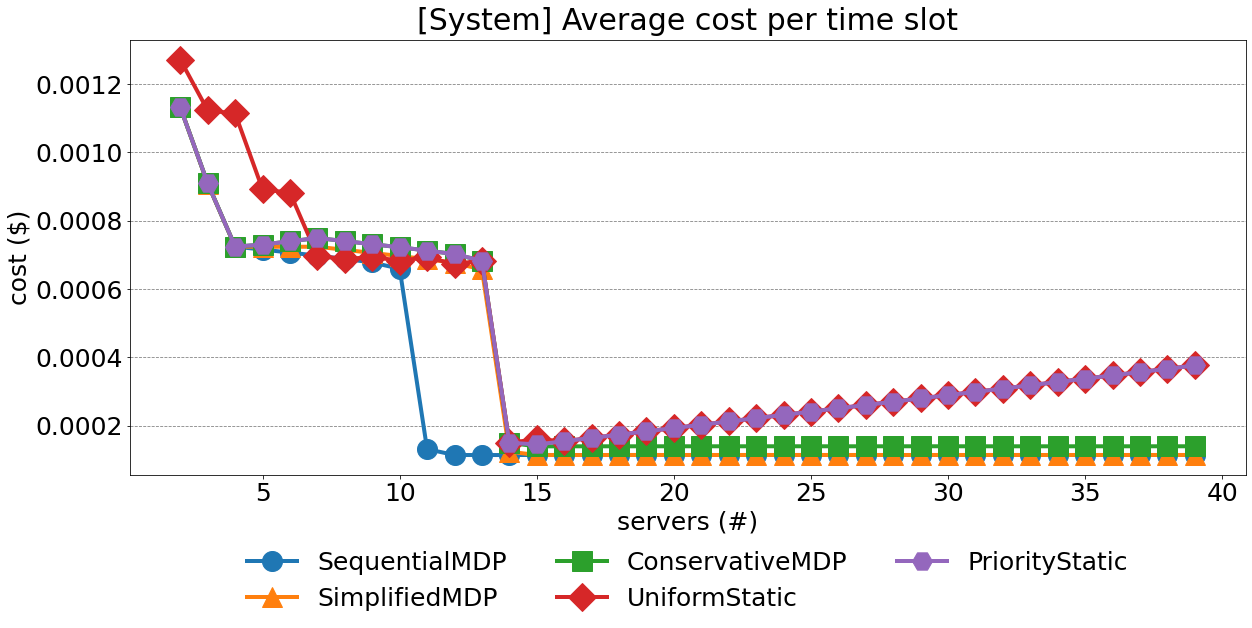

In [294]:
# this version should be used for "sameservice", two different services should have a separate code
markers = ['o', '^', 's', 'D', 'H']

ax = (df_cost_slice_0 + df_cost_slice_1).plot(
        kind='line',
        figsize=(20, 8),
        linewidth=4
    )

for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])
    line.set_markersize(20)

ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_title(f"[System] Average cost per time slot", pad=10)
ax.set_ylabel('cost ($)')
ax.set_xlabel('servers (#)')

plt.rcParams.update({'font.size': 25})
fig_background_color = 'skyblue'
fig_border = 'steelblue'

bars = ax.patches

hatches = [p for p in patterns for i in range(len(df_processed_on_time_slice_0))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    bar.set_edgecolor('gainsboro')
    
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}cost_allslice_allpolicy_JUPYTER", bbox_inches='tight')

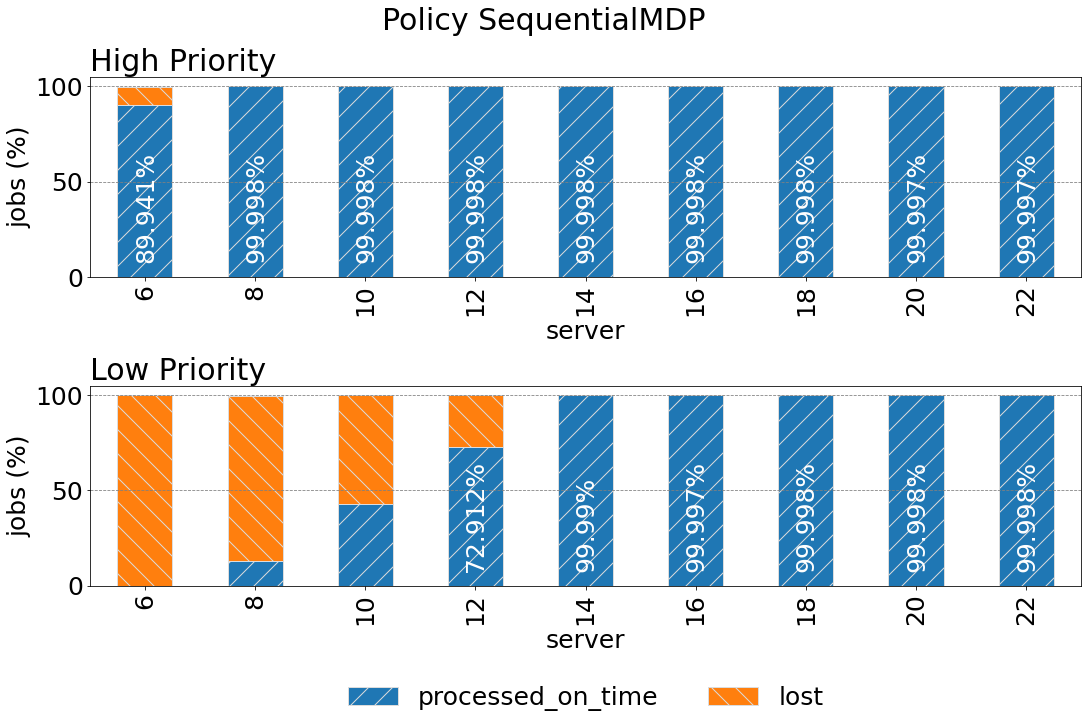

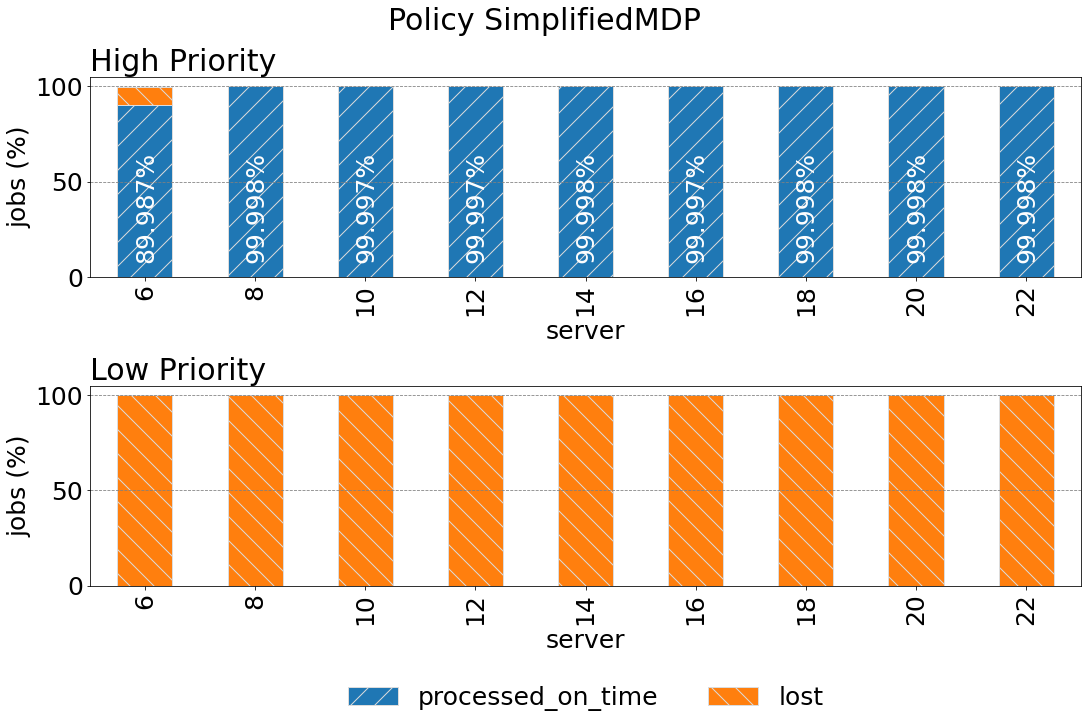

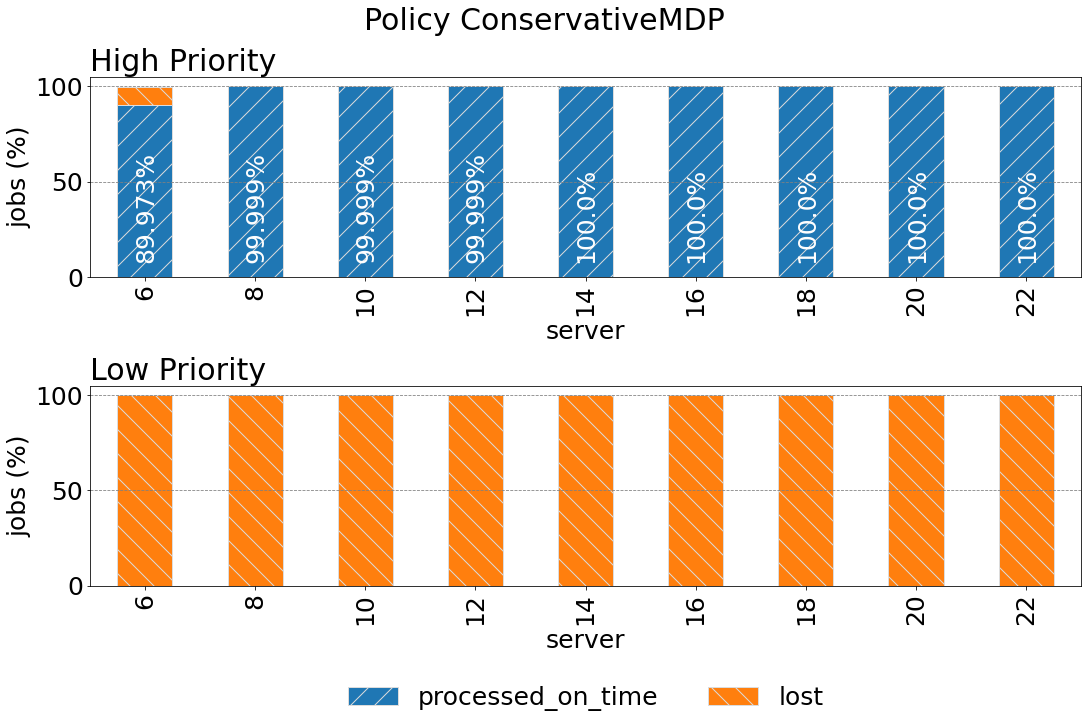

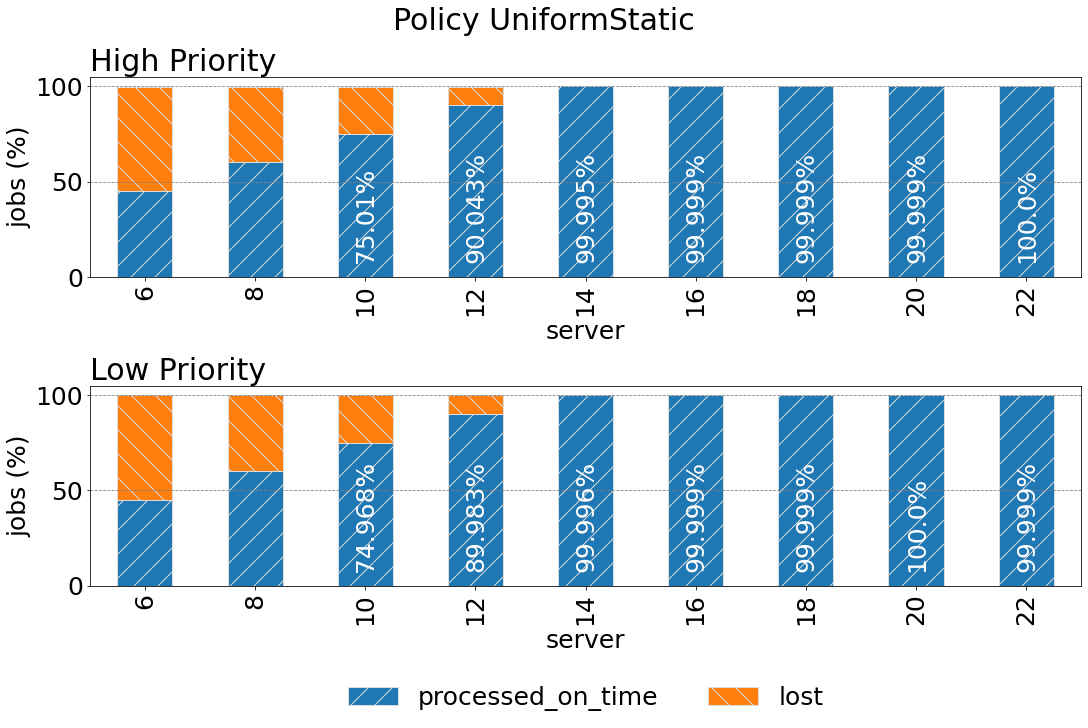

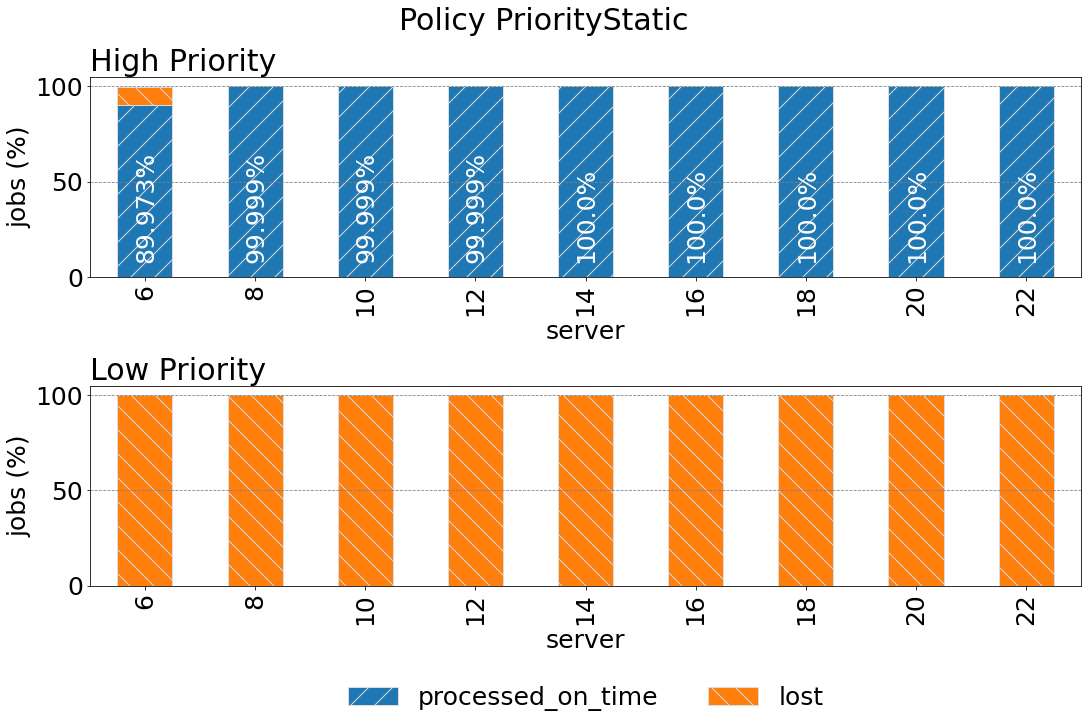

In [285]:
# this version should be used for "sameservice", two different services should have a separate code
patterns =('/','\\', '-')

new_df = deepcopy(dataframes)

#creating syntetic conservative mdp policy
a = deepcopy(dataframes[0])
a['name'] = 'ConservativeMDP'
a['slices'][0] = deepcopy(dataframes[3]['slices'][0])
a['slices'][1] = deepcopy(dataframes[1]['slices'][1])

new_df.insert(2, a)

policy_names = ["SequentialMDP", "SimplifiedMDP", "ConservativeMDP", "UniformStatic", "PriorityStatic"]
plt.rcParams.update({'font.size': 25})

for i in range(len(policy_names)):
    # df0 = new_df[0]['slices'][0][['processed_on_time', 'processed_too_late', 'lost']]
    # df1 = new_df[0]['slices'][1][['processed_on_time', 'processed_too_late', 'lost']]
    df0 = new_df[i]['slices'][0][['processed_on_time', 'lost']]
    df1 = new_df[i]['slices'][1][['processed_on_time', 'lost']]

    fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(15, 10))

    axs[0].set_title("High Priority", loc="left")
    axs[1].set_title("Low Priority", loc="left")
    axs[0].set_ylabel("jobs (%)")
    axs[1].set_ylabel("jobs (%)")

    axs[1].set_xlabel('servers (#)')

    fig.suptitle(f"Policy {policy_names[i]}")
    df0.plot(
        kind='bar',
        stacked=True,
        width=0.5,
        ax=axs[0],
        legend=False
    )

    axs[0].grid(axis='y', which='both', color='grey', linestyle='dashed')
    df1.plot(
        kind='bar',
        stacked=True,
        width=0.5,
        ax=axs[1],
        legend=False
    )

    axs[1].grid(axis='y', which='both', color='grey', linestyle='dashed')

    bars = axs[0].patches
    hatches = [p for p in patterns for i in range(len(df0))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
        bar.set_edgecolor('gainsboro')
        
    bars = axs[1].patches
    hatches = [p for p in patterns for i in range(len(df0))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
        bar.set_edgecolor('gainsboro')

    number_of_servers_max = len(df_processed_on_time_slice_0[policy_names[i]].tolist())
            
    for count, value in enumerate(axs[0].patches):
        if value.get_height() > 70 and count < number_of_servers_max:
            axs[0].text(value.get_x() + 0.15, 10,
                    str(truncate((value.get_height()), 3)) + '%', fontsize=25, color='white', rotation=90)
     
    for count, value in enumerate(axs[1].patches):
        if value.get_height() > 70 and count < number_of_servers_max:
            axs[1].text(value.get_x() + 0.15, 10,
                    str(truncate((value.get_height()), 3)) + '%', fontsize=25, color='white', rotation=90)



    
    axs[1].legend(bbox_to_anchor=(0.5, -0.45), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)
    plt.savefig(f"{OUTPUT_DIRECTORY_PATH}overview_policy-{policy_names[i]}_JUPYTER", bbox_inches='tight')

In [281]:
df_processed_on_time_slice_0

,SequentialMDP,SimplifiedMDP,ConservativeMDP,UniformStatic,PriorityStatic
server,,,,,
6,89.941789,89.987850,89.973046,44.958957,89.973046
8,99.998700,99.998500,99.999450,60.016937,99.999450
10,99.998475,99.997901,99.999950,75.010715,99.999950
12,99.998224,99.997751,100.000000,90.043844,100.000000
14,99.998350,99.998100,100.000000,99.995950,100.000000
16,99.998375,99.997999,100.000000,99.999550,100.000000
18,99.998575,99.998100,100.000000,99.999950,100.000000
20,99.997874,99.998400,100.000000,99.999975,100.000000
22,99.997801,99.998750,100.000000,100.000000,100.000000


In [199]:
df_processed_on_time_slice_1

,SequentialMDP,SimplifiedMDP,ConservativeMDP,UniformStatic,PriorityStatic
server,,,,,
6,0.000000,0.0,0.0,44.972640,0.0
8,12.761880,0.0,0.0,60.011696,0.0
10,42.896302,0.0,0.0,74.968143,0.0
12,72.912672,0.0,0.0,89.983652,0.0
14,99.990572,0.0,0.0,99.996150,0.0
16,99.997899,0.0,0.0,99.999700,0.0
18,99.998600,0.0,0.0,99.999775,0.0
20,99.998400,0.0,0.0,100.000000,0.0
22,99.998300,0.0,0.0,100.000000,0.0


In [267]:
round(0/2)

0

Follows NEW plots for two slices with different requirements

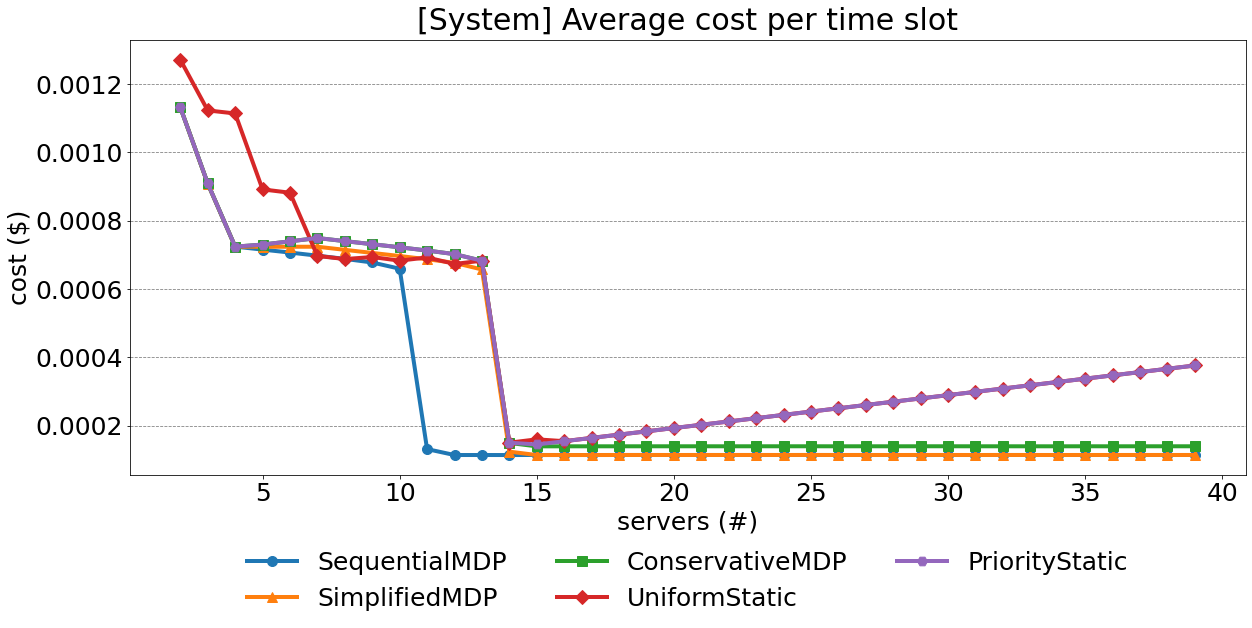

In [303]:
markers = ['o', '^', 's', 'D', 'H']

ax = (df_cost_slice_0 + df_cost_slice_1).plot(
        kind='line',
        figsize=(20, 8),
        linewidth=4
    )

for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])
    line.set_markersize(10)

ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_title(f"[System] Average cost per time slot", pad=10)
ax.set_ylabel('cost ($)')
ax.set_xlabel('servers (#)')

plt.rcParams.update({'font.size': 25})
fig_background_color = 'skyblue'
fig_border = 'steelblue'

bars = ax.patches

hatches = [p for p in patterns for i in range(len(df_processed_on_time_slice_0))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    bar.set_edgecolor('gainsboro')
    
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, borderaxespad=0.01, frameon=False)

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}cost_allslice_allpolicy_JUPYTER", bbox_inches='tight')

In [313]:
df_cost_slice_0.iloc[:,5]

IndexError: single positional indexer is out-of-bounds